# Detecção de comunidades


In [175]:
# #Bibliotecas necessárias
# !pip install python-louvain
# !pip install leidenalg
# !pip install cairocffi
# !pip install --upgrade scipy
# !pip install --upgrade networkx[default]

# #No linux precisei instalar antes do pycairo: sudo apt install libcairo2-dev pkg-config python3-dev
# !pip install pycairo

In [176]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import colormaps
import sys
from itertools import combinations
from datetime import datetime
import pandas as pd
import numpy as np
sys.path.append('../utils')
from mapa_estudantes import get_historico_completo, gerar_estudantes, get_disciplinas_matriz_844
from disciplina import trilhas

# import igraph as ig

def printall(string):
    pd.set_option('display.max_rows', None)
    print(string)
    pd.set_option('display.max_rows', 15)

In [177]:
dados_estudantes = [
    # "../excel/dados_historicos_alunos_de_EngComputacaoCuritiba desistentes mudancas curso.csv",
    "../excel/dados_historicos_alunos_de_EngComputacaoCuritiba formados.csv",
    "../excel/dados_historicos_alunos_de_EngComputacaoCuritiba regulares.csv",
    # "../excel/dados_historicos_alunos_de_EngComputacaoCuritiba trancados.csv",
]

dfs = []
for file in dados_estudantes:
    dfs.append(pd.read_csv(file, delimiter=";"))

df = pd.concat(dfs, ignore_index=True)
df.rename(
    columns={"PERIODO": "PERIODO_CURSO", "PERIODO.1": "PERIODO_ANO"}, inplace=True
)
# df["INGRESSO"] = pd.to_datetime(df["INGRESSO"], format="%d/%m/%y")
df["INGRESSO"] = pd.to_datetime(df["INGRESSO"], format="mixed")
df["SEMESTRE"] = df["ANO"].astype(str) + "." + df["PERIODO_ANO"].astype(str)
pd.set_option("display.width", 1000)
# pd.set_option('display.max_rows', None)
print(df)

       ID_ANONIMO      CR PERIODO_CURSO   INGRESSO  CODIGO   ANO  PERIODO_ANO NOTA  CH SITUACAOALUNO SEMESTRE
0           13236  0,6826            10 2007-12-07   IF68E  2012            1  8,2  60       Formado   2012.1
1           13236  0,6826            10 2007-12-07   IF35J  2007            2    7  60       Formado   2007.2
2           13236  0,6826            10 2007-12-07   MA33K  2007            2    0  60       Formado   2007.2
3           13236  0,6826            10 2007-12-07  F2D070  2007            2  8,8  75       Formado   2007.2
4           13236  0,6826            10 2007-12-07  E1D000  2007            2    0  30       Formado   2007.2
...           ...     ...           ...        ...     ...   ...          ...  ...  ..           ...      ...
50021      261036   0,695             2 2023-09-08  ICSF13  2023            2  6,6  90       Regular   2023.2
50022      261911  0,7143             1 2023-08-17  ICSD21  2023            2    8  45       Regular   2023.2
50023     

In [178]:
# Obter os dados da matriz 844
disciplinas_844 = get_disciplinas_matriz_844()
disciplinas_844

{'CSD20': Disciplina(periodo=1, trilha=None, codigo='CSD20', disciplina='INTRODUÇÃO À LÓGICA PARA A COMPUTAÇÃO', modelo_disciplina='FORMAÇÃO PROFISSIONAL', aulas_teoricas_semanais=3, aulas_praticas_semanais=0, total_de_aulas_semanais=3, total_de_aulas_de_aps=3, total_de_aulas_de_apcc=0, total_de_horas_de_ad=6, carga_horaria_total=45, pre_requisitos=[], disciplinas_equivalentes={'ICSD20': 45, 'IF61B': 60}),
 'CSF13': Disciplina(periodo=1, trilha=None, codigo='CSF13', disciplina='FUNDAMENTOS DE PROGRAMAÇÃO 1', modelo_disciplina='FORMAÇÃO PROFISSIONAL', aulas_teoricas_semanais=3, aulas_praticas_semanais=3, total_de_aulas_semanais=6, total_de_aulas_de_aps=6, total_de_aulas_de_apcc=0, total_de_horas_de_ad=0, carga_horaria_total=90, pre_requisitos=[], disciplinas_equivalentes={'ICSF13': 90, 'IF61C': 90}),
 'FI71S': Disciplina(periodo=1, trilha=None, codigo='FI71S', disciplina='FÍSICA TEÓRICA A', modelo_disciplina='FORMAÇÃO BÁSICA E CIENTÍFICA', aulas_teoricas_semanais=4, aulas_praticas_seman

In [179]:
# Obter um mapeamento de disciplinas equivalentes
mapeamento_equivalentes = {}
for disciplina in disciplinas_844.values():
    for equivalente in disciplina.disciplinas_equivalentes.keys():
        mapeamento_equivalentes[equivalente] = disciplina.codigo

mapeamento_equivalentes

{'ICSD20': 'CSD20',
 'IF61B': 'CSD20',
 'ICSF13': 'CSF13',
 'IF61C': 'CSF13',
 'FIS7F1': 'FI71S',
 'FI71M': 'FI71S',
 'FI71Z': 'FI71S',
 'MAT7C1': 'MA71A',
 'MA61A': 'MA71A',
 'MA71Z': 'MA71A',
 'MAT7AL': 'MA71B',
 'MAT7GA': 'MA71B',
 'MA61B': 'MA71B',
 'MA71I': 'MA71B',
 'MA71Y': 'MA71B',
 'MA72I': 'MA71B',
 'ICSE20': 'CSE20',
 'IF62C': 'CSE20',
 'ICSF20': 'CSF20',
 'IF62E': 'CSF20',
 'ELEX10': 'EEX11',
 'ELE11': 'EEX11',
 'FIS7E1': 'FI72N',
 'FI61A': 'FI72N',
 'FI62A': 'FI72N',
 'FI71A': 'FI72N',
 'FI71Y': 'FI72N',
 'FI72A': 'FI72N',
 'FI72B': 'FI72N',
 'FIS7F2': 'FI72S',
 'FI72M': 'FI72S',
 'FI72Z': 'FI72S',
 'MA62A': 'MA72A',
 'MA72H': 'MA72A',
 'MA75D': 'MA72A',
 'QBI7QE': 'QB70C',
 'QBI7QT': 'QB70C',
 'QB64A': 'QB70C',
 'QB70D': 'QB70C',
 'QB70I': 'QB70C',
 'ICSF30': 'CSF30',
 'IF63C': 'CSF30',
 'ELEB20': 'EEB21',
 'ELP21': 'EEB21',
 'EL63A': 'EEB21',
 'EL72F': 'EEB21',
 'ELEX20': 'EEX21',
 'ELE41': 'EEX21',
 'ELX91': 'EEX21',
 'FIS7F3': 'FI73S',
 'FI73M': 'FI73S',
 'FI74K': 'MA7

In [180]:
# Obter nome de disciplinas eletivas
eletivas = pd.read_csv("../excel/Eletivas.csv", delimiter=",")
mapa_eletivas = {}
for index, row in eletivas.iterrows():
    mapa_eletivas[row["CODIGO"]] = row["DISCIPLINA"]

print(mapa_eletivas)

{'CE70B': 'Comunicação oral e escrita', 'EL71D': 'Introdução à Engenharia Mecatrônica', 'DI81B': 'Criatividade', 'DI61B': 'História da Arte 1', 'GE73H': 'Comportamento Humano Nas Organizações', 'CL73A': 'Letras Inglês Básico 2', 'CL74A': 'Língua Inglesa – Intermediário 1', 'ME66J': 'Metodologia de Projetos', 'FI70C': 'Princípios de Resistências dos Materiais', 'EL64G': 'Metrologia Elétrica', 'EL64E': 'Materiais e Dispositivos', 'MA74C': 'Cálculo Diferencial e Integral IV B', 'DI81A': 'História da Arte', 'ED70Q': 'Didática 1', 'MA77J': 'História da Matemática A', 'DI62G': 'Computação Gráfica 1', 'DI64G': 'Fotografia', 'DI65H': 'Fundamentos de Interação', 'MA75K': 'Fundamentos de Álgebra', 'ES70Q': 'Sociedade e Política no Brasil', 'GE73D': 'Instituições De Direito'}


In [181]:
def get_tipo_disciplina(disciplina):
    if disciplina in disciplinas_844:
        return (
            disciplinas_844[disciplina].trilha
            if disciplinas_844[disciplina].trilha
            else "OBRIGATÓRIA"
        )
    elif disciplina in mapa_eletivas:
        return "ELETIVA"
    else:
        return "NÃO MAPEADA"


df = df.replace({"CODIGO": mapeamento_equivalentes})
df["DISCIPLINA"] = df["CODIGO"].apply(
    lambda x: disciplinas_844[x].disciplina if x in disciplinas_844 else None
)
df["TRILHA"] = df["CODIGO"].apply(get_tipo_disciplina)

In [182]:
df_844 = df.loc[
    (df["INGRESSO"] >= datetime(2017, 1, 1)) & (df["INGRESSO"] <= datetime(2023, 1, 1))
]
print(f'Alunos na matriz 844: {df_844["ID_ANONIMO"].unique().size}')

# pd.set_option('display.max_rows', None)
pd.set_option("display.max_rows", 15)
df_844

Alunos na matriz 844: 326


ID_ANONIMO      CR PERIODO_CURSO   INGRESSO   CODIGO   ANO  PERIODO_ANO NOTA  CH SITUACAOALUNO SEMESTRE                            DISCIPLINA       TRILHA
20694      145077  0,7908            10 2017-02-03    QB70E  2022            1    9  30       Formado   2022.1                  CIÊNCIAS DO AMBIENTE  OBRIGATÓRIA
20695      145077  0,7908            10 2017-02-03    ES70P  2020            2  7,2  45       Formado   2020.2  FILOSOFIA DA CIÊNCIA E DA TECNOLOGIA  OBRIGATÓRIA
20696      145077  0,7908            10 2017-02-03    MA71A  2017            1  9,2  90       Formado   2017.1      CÁLCULO DIFERENCIAL E INTEGRAL 1  OBRIGATÓRIA
20697      145077  0,7908            10 2017-02-03    FI72S  2018            1  8,9  60       Formado   2018.1                      FÍSICA TEÓRICA B  OBRIGATÓRIA
20698      145077  0,7908            10 2017-02-03    FI72S  2017            2    4  60       Formado   2017.2                      FÍSICA TEÓRICA B  OBRIGATÓRIA
...           ...     ...           ...        ...      ...   ...          ...  ...  ..           ...      ...                                   ...          ...
49725      251700  0,6279             2 2022-08-25    CSF13  2022            2  4,2  90       Regular   2022.2          FUNDAMENTOS DE PROGRAMAÇÃO 1  OBRIGATÓRIA
49726      251700  0,6279             2 2022-08-25    MA71A  2022            2    6  90       Regular   2022.2      CÁLCULO DIFERENCIAL E INTEGRAL 1  OBRIGATÓRIA
49727      251700  0,6279             2 2022-08-25    FI71S  2022            2  2,9  60       Regular   2022.2                      FÍSICA TEÓRICA A  OBRIGATÓRIA
49728      251700  0,6279             2 2022-08-25    MA71B  2022            2    6  90       Regular   2022.2  GEOMETRIA ANALÍTICA E ÁLGEBRA LINEAR  OBRIGATÓRIA
49729      251700  0,6279             2 2022-08-25  ENADE I  2022            2  NaN   0       Regular   2022.2                     ENADE INGRESSANTE  OBRIGATÓRIA

[13874 rows x 13 columns]

In [183]:
# Disciplinas eletivas de alunos da matriz 844
eletivas = list(df_844.loc[df_844["DISCIPLINA"].isna()]["CODIGO"].unique())
for eletiva in eletivas:
    print(
        f'{eletiva} - {mapa_eletivas[eletiva] if eletiva in mapa_eletivas else "NÃO MAPEADA"}'
    )

CE70B - Comunicação oral e escrita
EL71D - Introdução à Engenharia Mecatrônica
DI81B - Criatividade
DI61B - História da Arte 1
GE73H - Comportamento Humano Nas Organizações
CL73A - Letras Inglês Básico 2
CL74A - Língua Inglesa – Intermediário 1
ME66J - Metodologia de Projetos
FI70C - Princípios de Resistências dos Materiais
EL64G - Metrologia Elétrica
EL64E - Materiais e Dispositivos
MA74C - Cálculo Diferencial e Integral IV B
DI81A - História da Arte
ED70Q - Didática 1
MA77J - História da Matemática A
DI62G - Computação Gráfica 1
DI64G - Fotografia
DI65H - Fundamentos de Interação
MA75K - Fundamentos de Álgebra
ES70Q - Sociedade e Política no Brasil
GE73D - Instituições De Direito
ME66I - NÃO MAPEADA
ME67C - NÃO MAPEADA
EL84H - NÃO MAPEADA
ES7AK - NÃO MAPEADA
GE73E - NÃO MAPEADA
CL62B - NÃO MAPEADA
ES70R - NÃO MAPEADA
CE75D - NÃO MAPEADA
CSG30 - NÃO MAPEADA
DI81C - NÃO MAPEADA
CL74D - NÃO MAPEADA
GE72D - NÃO MAPEADA
GE79A - NÃO MAPEADA
AU62M - NÃO MAPEADA
CL72B - NÃO MAPEADA
ES61A - N

### A partir daqui vou utilizar apenas os estudantes da matriz 844, ou seja que ingressaram no periodo [2017-2022]


In [184]:
# Exibir status dos alunos da matriz 844
df_844.groupby(["ID_ANONIMO"]).agg({"SITUACAOALUNO": "last"}).groupby(
    ["SITUACAOALUNO"]
).size()

SITUACAOALUNO
Formado     18
Regular    308
dtype: int64

### Obter o grafo de disciplinas

- Cada nó representa uma disciplina
- Uma aresta da disciplina d1 para disciplina d2 significa que um aluno cursou a disciplina d1 e no periodo seguinte cursou a disciplina d2
- O peso da aresta indica o número de vezes que um aluno cursou a disciplina d1 e no semestre seguinte cursou a disciplina d2


In [185]:
# Remover disciplinas com trilha NÃO MAPEADA ou ELETIVA
df_844_curso = df_844.loc[
    (df_844["TRILHA"] != "NÃO MAPEADA") & (df_844["TRILHA"] != "ELETIVA")
]
df_844_optativas = df_844_curso.loc[(df_844["TRILHA"] != "OBRIGATÓRIA")]
printall(df_844_curso)

       ID_ANONIMO      CR   PERIODO_CURSO   INGRESSO   CODIGO   ANO  PERIODO_ANO NOTA   CH SITUACAOALUNO SEMESTRE                                         DISCIPLINA       TRILHA
20694      145077  0,7908              10 2017-02-03    QB70E  2022            1    9   30       Formado   2022.1                               CIÊNCIAS DO AMBIENTE  OBRIGATÓRIA
20695      145077  0,7908              10 2017-02-03    ES70P  2020            2  7,2   45       Formado   2020.2               FILOSOFIA DA CIÊNCIA E DA TECNOLOGIA  OBRIGATÓRIA
20696      145077  0,7908              10 2017-02-03    MA71A  2017            1  9,2   90       Formado   2017.1                   CÁLCULO DIFERENCIAL E INTEGRAL 1  OBRIGATÓRIA
20697      145077  0,7908              10 2017-02-03    FI72S  2018            1  8,9   60       Formado   2018.1                                   FÍSICA TEÓRICA B  OBRIGATÓRIA
20698      145077  0,7908              10 2017-02-03    FI72S  2017            2    4   60       Formado   201

In [186]:
G_curso = nx.Graph()
disciplinas = df_844_curso["CODIGO"].unique()
G_curso.add_nodes_from(disciplinas)

# Exibir o número de disciplinas
print(f"Número de disciplinas: {G_curso.number_of_nodes()}")

def semestres_consecutivos_1_periodo(semestre1, semestre2):
    ano1, periodo1 = map(int, semestre1.split("."))
    ano2, periodo2 = map(int, semestre2.split("."))
    
    if ano1 == ano2:
        return periodo1 + 1 == periodo2
    elif ano1 + 1 == ano2:
        return periodo1 == 2 and periodo2 == 1
    return False

def semestres_consecutivos_2_periodos(semestre1, semestre2):
    ano1, periodo1 = map(int, semestre1.split("."))
    ano2, periodo2 = map(int, semestre2.split("."))
    
    if ano1 == ano2:
        return periodo1 + 1 == periodo2
    elif ano1 + 1 == ano2:
        return not (periodo1 == 1 and periodo2 == 2)
    return False

semestres_consecutivos = semestres_consecutivos_2_periodos


for data in df_844_curso.groupby(["ID_ANONIMO"]):
    estudante = data[0][0]
    dados_estudante = data[1]
    disciplinas = (
        dados_estudante.sort_values(by=["SEMESTRE"])
        .groupby(["CODIGO"])
        .agg({"SEMESTRE": "last"})
        .sort_values(by=["SEMESTRE"])
        .itertuples()
    )
    for disc1, disc2 in combinations(disciplinas, 2):
        if semestres_consecutivos(disc1.SEMESTRE, disc2.SEMESTRE):
            if G_curso.has_edge(disc1.Index, disc2.Index):
                G_curso[disc1.Index][disc2.Index]["weight"] += 1
            else:
                G_curso.add_edge(disc1.Index, disc2.Index, weight=1)

print("Número de Arestas: ", len(G_curso.edges))
print("Número de Nós: ", len(G_curso.nodes))

Número de disciplinas: 122
Número de Arestas:  3248
Número de Nós:  122


In [187]:
G_optativas = nx.Graph()
disciplinas = df_844_optativas["CODIGO"].unique()
G_optativas.add_nodes_from(disciplinas)

# Exibir o número de disciplinas
print(f"Número de disciplinas optativas: {G_optativas.number_of_nodes()}")

for data in df_844_optativas.groupby(["ID_ANONIMO"]):
    estudante = data[0][0]
    dados_estudante = data[1]
    disciplinas = (
        dados_estudante.sort_values(by=["SEMESTRE"])
        .groupby(["CODIGO"])
        .agg({"SEMESTRE": "last"})
        .sort_values(by=["SEMESTRE"])
        .itertuples()
    )
    for disc1, disc2 in combinations(disciplinas, 2):
        if semestres_consecutivos(disc1.SEMESTRE, disc2.SEMESTRE):
            if G_optativas.has_edge(disc1.Index, disc2.Index):
                G_optativas[disc1.Index][disc2.Index]["weight"] += 1
            else:
                G_optativas.add_edge(disc1.Index, disc2.Index, weight=1)

print("Número de Arestas: ", len(G_optativas.edges))
print("Número de Nós: ", len(G_optativas.nodes))

Número de disciplinas optativas: 62
Número de Arestas:  211
Número de Nós:  62


In [188]:
RA_Paulo = 202266
RA_Adriano = 202250
RA_Cesar = 202417
RA_Daniel = 202688
RA_Ribas = 202689
RA_Felipe = 160776
RA_Hadryan = 202696

RA_Aluno = 202701

G_aluno_optativas = nx.Graph()
disciplinas = df_844_optativas["CODIGO"].unique()
G_aluno_optativas.add_nodes_from(disciplinas)

# Exibir o número de disciplinas
print(f"Número de disciplinas optativas: {G_aluno_optativas.number_of_nodes()}")
df_844_optativas_aluno = df_844_optativas[df_844_optativas["ID_ANONIMO"] == RA_Aluno]
print(df_844_optativas_aluno)

for data in df_844_optativas_aluno.groupby(["ID_ANONIMO"]):
    estudante = data[0][0]
    dados_estudante = data[1]
    disciplinas = (
        dados_estudante.sort_values(by=["SEMESTRE"])
        .groupby(["CODIGO"])
        .agg({"SEMESTRE": "last"})
        .sort_values(by=["SEMESTRE"])
        .itertuples()
    )
    for disc1, disc2 in combinations(disciplinas, 2):
        if semestres_consecutivos(disc1.SEMESTRE, disc2.SEMESTRE):
            if G_aluno_optativas.has_edge(disc1.Index, disc2.Index):
                G_aluno_optativas[disc1.Index][disc2.Index]["weight"] += 1
            else:
                G_aluno_optativas.add_edge(disc1.Index, disc2.Index, weight=1)

print("Número de Arestas: ", len(G_aluno_optativas.edges))
print("Número de Nós: ", len(G_aluno_optativas.nodes))

Número de disciplinas optativas: 62
       ID_ANONIMO      CR PERIODO_CURSO   INGRESSO CODIGO   ANO  PERIODO_ANO NOTA  CH SITUACAOALUNO SEMESTRE                                      DISCIPLINA TRILHA
41751      202701  0,8872            10 2018-05-03  MA7AV  2019            1    8  45       Regular   2019.1            TÓPICOS MATEMÁTICOS PARA ENGENHEIROS    973
41767      202701  0,8872            10 2018-05-03  MA70C  2023            1    8  60       Regular   2023.1                                CÁLCULO NUMÉRICO    966
41769      202701  0,8872            10 2018-05-03  ED70T  2023            1    0  30       Regular   2023.1                                        LIBRAS A    973
41774      202701  0,8872            10 2018-05-03  CSM45  2022            2  9,3  60       Regular   2022.2                             COMPUTAÇÃO EM NUVEM    972
41776      202701  0,8872            10 2018-05-03  CSA41  2022            2   10  60       Regular   2022.2                      COMPLEXIDADE C

In [189]:
G_aluno_curso = nx.Graph()
disciplinas = df_844_curso["CODIGO"].unique()
G_aluno_curso.add_nodes_from(disciplinas)

# Exibir o número de disciplinas
print(f"Número de disciplinas optativas: {G_aluno_curso.number_of_nodes()}")
df_844_curso_aluno = df_844_curso[df_844_curso["ID_ANONIMO"] == RA_Aluno]
print(df_844_curso_aluno)

for data in df_844_curso_aluno.groupby(["ID_ANONIMO"]):
    estudante = data[0][0]
    dados_estudante = data[1]
    disciplinas = (
        dados_estudante.sort_values(by=["SEMESTRE"])
        .groupby(["CODIGO"])
        .agg({"SEMESTRE": "last"})
        .sort_values(by=["SEMESTRE"])
        .itertuples()
    )
    for disc1, disc2 in combinations(disciplinas, 2):
        if semestres_consecutivos(disc1.SEMESTRE, disc2.SEMESTRE):
            if G_aluno_curso.has_edge(disc1.Index, disc2.Index):
                G_aluno_curso[disc1.Index][disc2.Index]["weight"] += 1
            else:
                G_aluno_curso.add_edge(disc1.Index, disc2.Index, weight=1)

print("Número de Arestas: ", len(G_aluno_curso.edges))
print("Número de Nós: ", len(G_aluno_curso.nodes))

Número de disciplinas optativas: 122
       ID_ANONIMO      CR PERIODO_CURSO   INGRESSO   CODIGO   ANO  PERIODO_ANO NOTA  CH SITUACAOALUNO SEMESTRE                                 DISCIPLINA       TRILHA
41723      202701  0,8872            10 2018-05-03    CSD20  2018            1  9,5  45       Regular   2018.1      INTRODUÇÃO À LÓGICA PARA A COMPUTAÇÃO  OBRIGATÓRIA
41724      202701  0,8872            10 2018-05-03  ENADE I  2018            1  NaN   0       Regular   2018.1                          ENADE INGRESSANTE  OBRIGATÓRIA
41725      202701  0,8872            10 2018-05-03    MA71A  2018            1  9,8  90       Regular   2018.1           CÁLCULO DIFERENCIAL E INTEGRAL 1  OBRIGATÓRIA
41726      202701  0,8872            10 2018-05-03    MA71B  2018            1  9,3  90       Regular   2018.1       GEOMETRIA ANALÍTICA E ÁLGEBRA LINEAR  OBRIGATÓRIA
41727      202701  0,8872            10 2018-05-03    CSW30  2020            1  9,9  60       Regular   2020.1  ARQUITETURA E OR

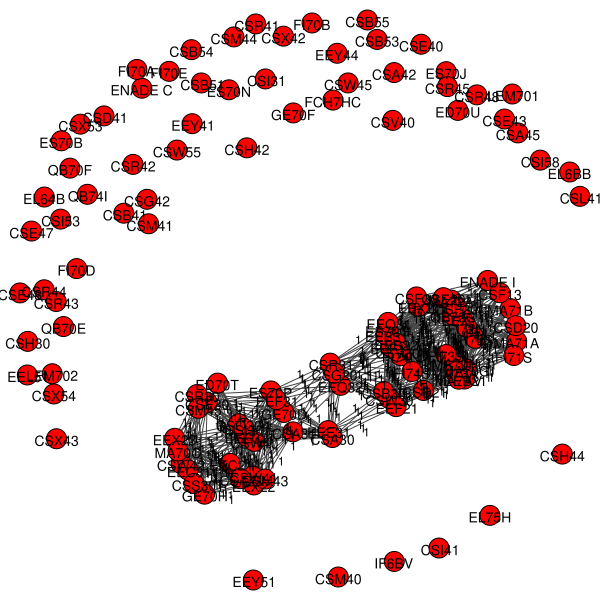

In [190]:
import leidenalg as la
import igraph as ig

H_aluno_curso = ig.Graph.from_networkx(G_aluno_curso)
H_curso = ig.Graph.from_networkx(G_curso)
H_optativas = ig.Graph.from_networkx(G_optativas)
H_aluno_optativas = ig.Graph.from_networkx(G_aluno_optativas)

# layout = H_aluno_curso.layout_davidson_harel()
# layout = H_aluno_curso.layout_fruchterman_reingold()
# layout = H_aluno_curso.layout_graphopt()
layout = H_aluno_curso.layout_kamada_kawai()
# layout = H_aluno_curso.layout_mds()
ig.plot(H_aluno_curso, edge_label=H_aluno_curso.es["weight"], layout=layout, vertex_label=H_aluno_curso.vs["_nx_name"])

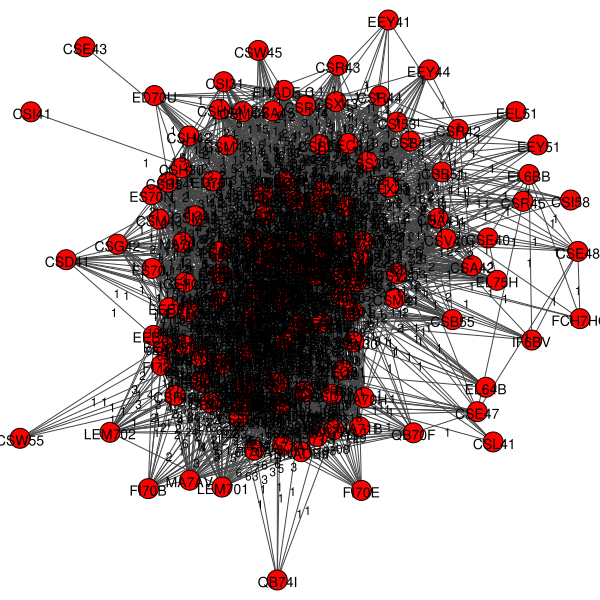

In [191]:
layout = H_curso.layout_kamada_kawai()
ig.plot(H_curso, edge_label=H_curso.es["weight"], layout=layout, vertex_label=H_curso.vs["_nx_name"])

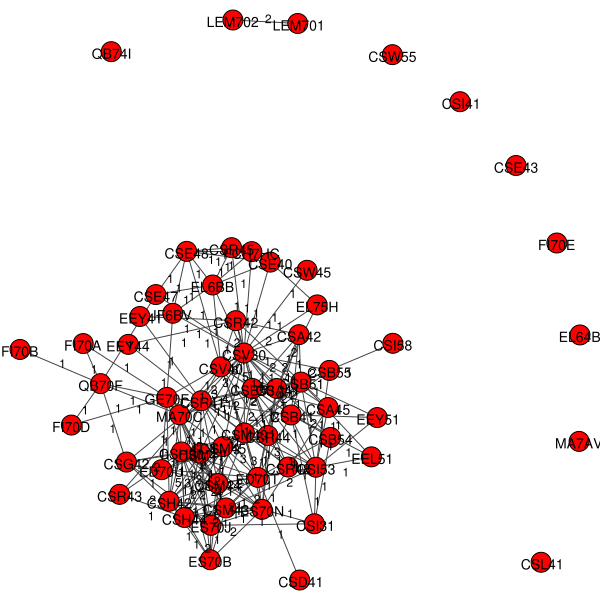

In [192]:
layout = H_optativas.layout_kamada_kawai()
ig.plot(H_optativas, edge_label=H_optativas.es["weight"], layout=layout, vertex_label=H_optativas.vs["_nx_name"])

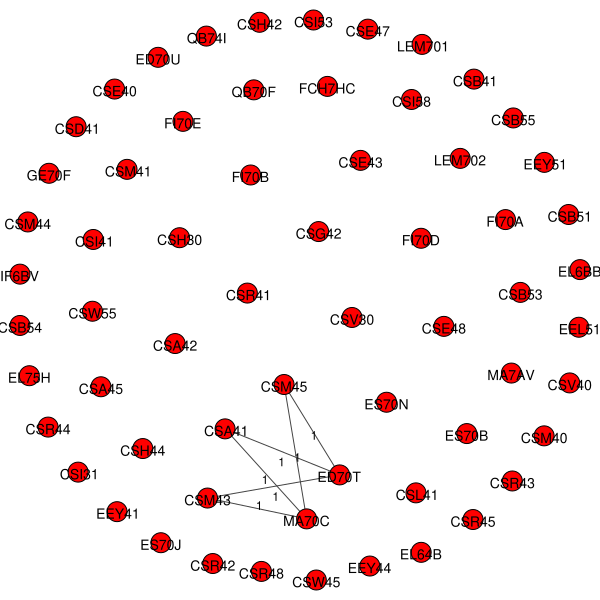

In [193]:
layout = H_aluno_optativas.layout_kamada_kawai()
ig.plot(H_aluno_optativas, edge_label=H_aluno_optativas.es["weight"], layout=layout, vertex_label=H_aluno_optativas.vs["_nx_name"])

In [201]:
# Remove 20% das arestas
import random

# G_compute = G_optativas
# G_compute = G_aluno_curso
# G_compute = G_optativas
G_compute = G_curso

proportion_edges = 0.2
edge_subset = list(random.sample(
    list(G_compute.edges()), int(proportion_edges * G_compute.number_of_edges())
))

print(edge_subset)

# Cria uma cópia do grafo e remove arestas
G_compute_train = G_compute.copy()
G_compute_train.remove_edges_from(edge_subset)


edge_subset_size = len(list(edge_subset))
print("Número de arestas removidas : %d" % edge_subset_size)
print("Número de arestas restantes : %d" % (G_compute.number_of_edges() - edge_subset_size))

[('CSM45', 'MA70C'), ('ES70P', 'EL6BB'), ('MA70G', 'MA70H'), ('QB70E', 'CSH30'), ('EEX23', 'CSS30'), ('ENADE I', 'CSG20'), ('CSB51', 'CSR41'), ('MA70H', 'CSV30'), ('CSW30', 'CSM44'), ('EEF31', 'CSD20'), ('CSE30', 'CSF30'), ('CSR45', 'CSE48'), ('EEB31', 'CSB54'), ('CSX54', 'CSM40'), ('GE70D', 'ENADE C'), ('MA70H', 'CSX53'), ('CSO30', 'CSM44'), ('FI73S', 'FI70A'), ('EEB21', 'EEB22'), ('CSF30', 'CSM41'), ('EEB22', 'CSD41'), ('FI74S', 'EEQ31'), ('CSO30', 'CSE40'), ('CSA31', 'CSR43'), ('CSR30', 'CSH30'), ('CSB51', 'CSR42'), ('QB70E', 'FI73S'), ('FI72S', 'FI73S'), ('EEF31', 'EL75H'), ('EEF31', 'EEQ31'), ('CSW30', 'CSB30'), ('CSW42', 'CSA45'), ('CSB30', 'CSA41'), ('EEB31', 'MA7AV'), ('CSG20', 'CSM41'), ('CSB30', 'CSB53'), ('MA72A', 'EEE31'), ('CSX53', 'CSE48'), ('ES70P', 'FI70D'), ('CSG20', 'CSS30'), ('EEF31', 'CSI53'), ('CSG42', 'QB70F'), ('ES70G', 'LEM702'), ('CSW40', 'CSF13'), ('CSE30', 'ES70N'), ('CSW42', 'EEY44'), ('FI71S', 'EEX22'), ('CSO30', 'CSB53'), ('CSR30', 'EL64B'), ('EEX21', 'CSX

## Jaccard coefficient

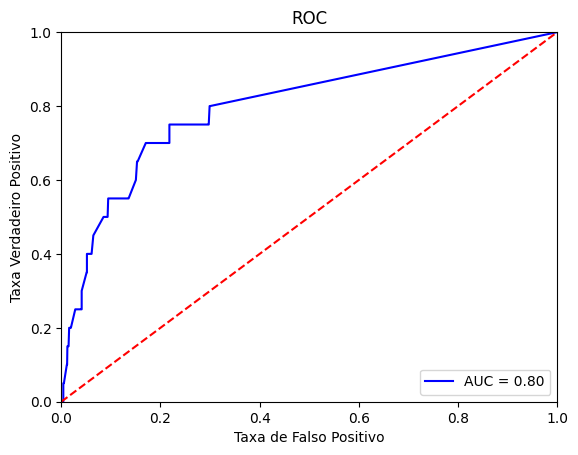

In [195]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Fazendo previsões com o jaccard
pred_jaccard = list(nx.jaccard_coefficient(G_compute_train))

score_jaccard = [s for (u, v, s) in pred_jaccard]
label_jaccard = [(u, v) in edge_subset for (u, v, s) in pred_jaccard]

# Computa o AUC score da curva ROC
fpr_jaccard, tpr_jaccard, _ = metrics.roc_curve(label_jaccard, score_jaccard)
auc_jaccard = roc_auc_score(label_jaccard, score_jaccard)


# Gráfico da curva ROC
plt.title("ROC")
plt.plot(fpr_jaccard, tpr_jaccard, "b", label="AUC = %0.2f" % auc_jaccard)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("Taxa Verdadeiro Positivo")
plt.xlabel("Taxa de Falso Positivo")
plt.show()

## Preferential Attachment

0.8477232667450059


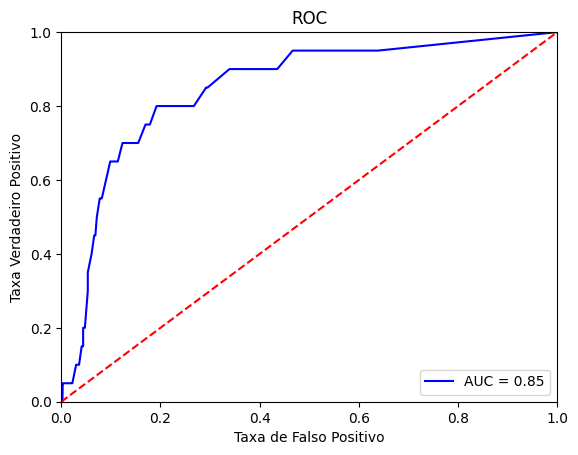

In [196]:
pred_prefAtch = list(nx.preferential_attachment(G_compute_train))

score_prefAtch = [s for (u, v, s) in pred_prefAtch]

label_prefAtch = [(u, v) in edge_subset for (u, v, s) in pred_prefAtch]

# Computa o AUC score da curva ROC
fpr_prefAtch, tpr_prefAtch, _ = metrics.roc_curve(label_prefAtch, score_prefAtch)
auc_prefAtch = roc_auc_score(label_prefAtch, score_prefAtch)
print(auc_prefAtch)


# Gráfico da curva ROC
plt.title("ROC")
plt.plot(fpr_prefAtch, tpr_prefAtch, "b", label="AUC = %0.2f" % auc_prefAtch)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("Taxa Verdadeiro Positivo")
plt.xlabel("Taxa de Falso Positivo")
plt.show()

## Resource Allocation

0.8339453584018802


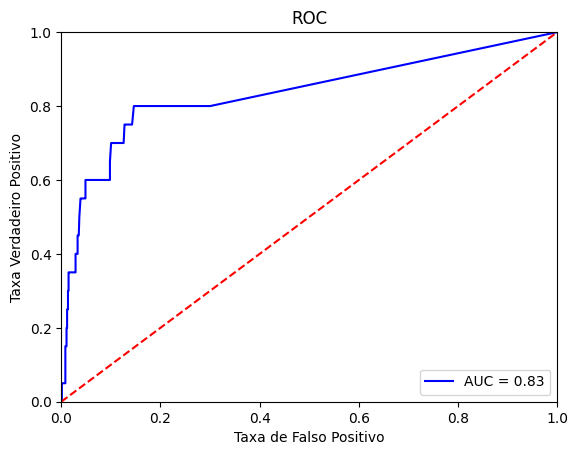

In [197]:
pred_ra = list(nx.resource_allocation_index(G_compute_train))

score_ra = [s for (u, v, s) in pred_ra]

label_ra = [(u, v) in edge_subset for (u, v, s) in pred_ra]

# Computa o AUC score da curva ROC
fpr_ra, tpr_ra, _ = metrics.roc_curve(label_ra, score_ra)
auc_ra = roc_auc_score(label_ra, score_ra)
print(auc_ra)


# Gráfico da curva ROC
plt.title("ROC")
plt.plot(fpr_ra, tpr_ra, "b", label="AUC = %0.2f" % auc_ra)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("Taxa Verdadeiro Positivo")
plt.xlabel("Taxa de Falso Positivo")
plt.show()

## Common Neighbor Centrality

0.8518948296122208


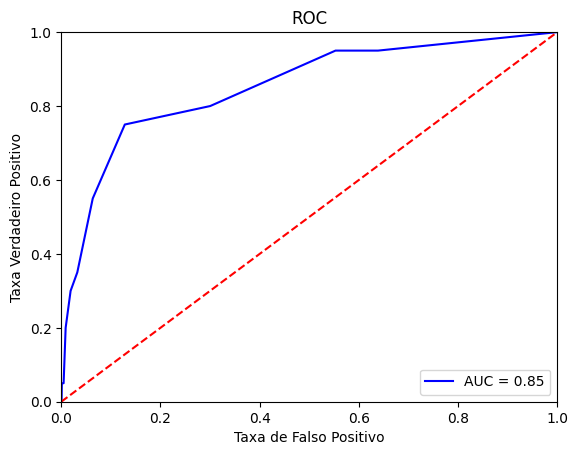

In [198]:
## Esta implementação depende do Networkx 2.6 que roda somente no python 3.7. Nesta máquina está com python 3.5

pred_CNC = list(nx.common_neighbor_centrality(G_compute_train))

score_CNC = [s for (u, v, s) in pred_CNC]

label_CNC = [(u, v) in edge_subset for (u, v, s) in pred_CNC]

fpr_CNC, tpr_CNC, _ = metrics.roc_curve(label_CNC, score_CNC)
auc_CNC = roc_auc_score(label_CNC, score_CNC)
print(auc_CNC)

# Gráfico da curva ROC
plt.title("ROC")
plt.plot(fpr_CNC, tpr_CNC, "b", label="AUC = %0.2f" % auc_CNC)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("Taxa Verdadeiro Positivo")
plt.xlabel("Taxa de Falso Positivo")
plt.show()

## Adamic-Adar

0.8349441833137485


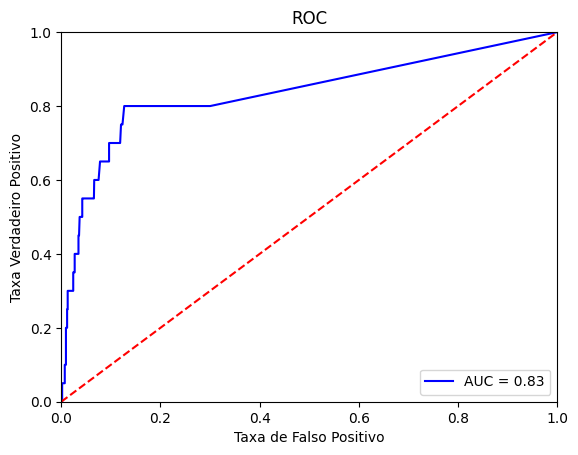

In [199]:
pred_adamic = list(nx.adamic_adar_index(G_compute_train))

score_adamic = [s for (u, v, s) in pred_adamic]

label_adamic = [(u, v) in edge_subset for (u, v, s) in pred_adamic]

fpr_adamic, tpr_adamic, _ = metrics.roc_curve(label_adamic, score_adamic)
auc_adamic = roc_auc_score(label_adamic, score_adamic)
print(auc_adamic)

# Gráfico da curva ROC
plt.title("ROC")
plt.plot(fpr_adamic, tpr_adamic, "b", label="AUC = %0.2f" % auc_adamic)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("Taxa Verdadeiro Positivo")
plt.xlabel("Taxa de Falso Positivo")
plt.show()

### Todas as ROC

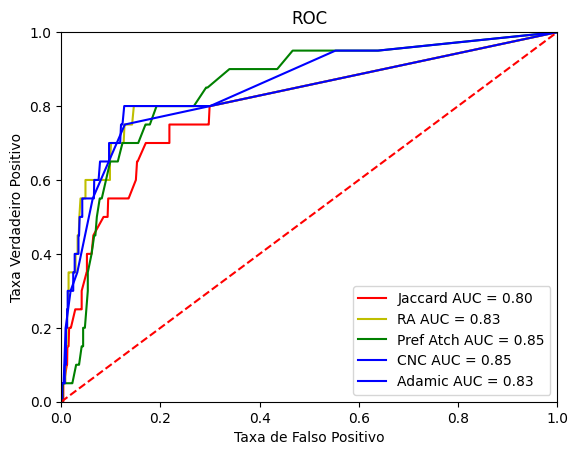

In [200]:
plt.title("ROC")
plt.plot(fpr_jaccard, tpr_jaccard, "r", label="Jaccard AUC = %0.2f" % auc_jaccard)
plt.plot(fpr_ra, tpr_ra, "y", label="RA AUC = %0.2f" % auc_ra)
plt.plot(fpr_prefAtch, tpr_prefAtch, "g", label="Pref Atch AUC = %0.2f" % auc_prefAtch)
plt.plot(fpr_CNC, tpr_CNC, "b", label="CNC AUC = %0.2f" % auc_CNC)
plt.plot(fpr_adamic, tpr_adamic, "b", label="Adamic AUC = %0.2f" % auc_adamic)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("Taxa Verdadeiro Positivo")
plt.xlabel("Taxa de Falso Positivo")
plt.show()